# Spin dynamics

In [1]:
## imports
 
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import *
import seaborn as sns

## System described here

We want to describe our system as it will be at first on the benchtop version.
We have the laser and the rf field $B_1$ along the z axis, the field to measure $B_0$ in the  yz-plane (according to [1]).

$$ \partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} = \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} \wedge \begin{pmatrix} 0 \\ \gamma B_0 \sin(\theta) \\ \gamma B_0 \cos(\theta) + \gamma B_{rf}\cos(\omega_{rf} t) \end{pmatrix} - \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} + R_{op} \begin{pmatrix}- S_x \\ - S_y \\ S_0-M_z\end{pmatrix} $$


$$
\partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} =
\begin{pmatrix} 
\left(\gamma B_0 \cos(\theta) +\gamma B_{rf} \cos(\omega_{rf} t) \right) S_y - \gamma B_0\sin(\theta) S_z  \\ 
- \left( \gamma B_0 \cos(\theta) + \gamma B_{rf} \cos(\omega_{rf} t) \right) S_x  \\ 
\gamma B_0 \sin(\theta) S_x 
\end{pmatrix}
- \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix}
+ R_{op} \begin{pmatrix} - S_x \\ - S_y \\ S_0 - S_z \end{pmatrix}.
$$




With :
- $\hat{S}$ : the spin operator
- $B_0$ : the bias field, i.e. the field we want to measure, assumed here as DC
- $B_{rf}$ : the intensity of the RF field to pump the spins
- $\gamma$ : the gyromagnetic ratio of $^{87}R_b$
- $\theta$ : the angle between the bias field $\vec{B_0}$ and the basis
- $\Gamma$ : the relaxation rate (assumed as equal to $\Gamma_{SE} + \Gamma_{SD} + \Gamma_{wall}$)
- $R_{op}$ : the optical pumping rate; $R_{op} = \sigma_{abs} \phi_{opt}$

In [2]:
## Constants
gamma = 7e9     # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
Gamma_natural = 36.10e6 #Hz

## Parameters
Gamma_list = np.logspace(np.log10(50), np.log10(50000), 10)
Gamma = 10000#50    # Relaxation rate (Hz) ; estimated from the google colab 'Vapour cell simulation'
#R_op = np.logspace(3,7,6)   # Optical pumping rate (Hz)

B_0 = 100e-6    # Static field intensity (Tesla)
B_1_list = np.logspace(-8,-2,10)
B_1 = 1e-3      # RF field intensity (Tesla)
theta = 90*np.pi/180

P_laser_list = np.logspace(np.log10(1e-7), np.log10(1e-5), num=10) # Laser power (W)
P_laser = 1e-6
beam_diameter = 1e-3 # self-explanatory (m)


P = 3e-1        # Cell pressure (Pa)
V = 3e-3*3e-3*1.9e-3 # Cell volume (m^3)
z_cell = 1.9e-3 # Cell length (m)
T_list = np.linspace(273.15, 273.15+100,10)   # Cell temperature (K)
T = 273.15+60
#figure of merit
magnitude_signal_photocurrent = []
SNR_list = []

I_sat = 44.84

## Derived parameters
omega = gamma * B_0    # Frequency of the RF field (Hz)

I_list = P_laser_list/(np.pi*(beam_diameter/2)**2) 
R_op_list = Gamma_natural*I_list/(I_list+I_sat)
I = P_laser/(np.pi*(beam_diameter/2)**2) # Laser intensity before the cell (W/m²)
R_op = Gamma_natural * (I)/(I+I_sat)

n_ideal_gas = P/(k*T)     # Rb density (m^-3)
n_list = 1/T_list*10**(21.866+4.312-4040/T_list)
n = 1/T*10**(21.866+4.312-4040/T)
N = P*V/(k*T) # Number of particles
S_0 = 1      # maximum magnetization

In [3]:
P_laser

1e-06

In [4]:
""" P_l = np.pi*(beam_diameter/2)*2 * R_op[0]/Gamma_natural*I_sat*(1/(1-R_op[0]/Gamma_natural))
P_l  """
T

333.15

In [5]:
def bloch_equations(t, S, gamma, B_0, B_1, omega, Gamma, R_op, S_0):
    Sx, Sy, Sz = S
    cos_omega_t = np.cos(omega * t)
    term1 = B_1 * cos_omega_t + B_0 * np.cos(theta)
    term2 = B_0 * np.sin(theta)

    dSxdt = gamma * term1 * Sy - gamma * term2 * Sz - (Gamma + R_op) * Sx
    dSydt =  - gamma * term1 * Sx - (Gamma + R_op) * Sy
    dSzdt = gamma * term2 * Sx - (Gamma) * Sz + R_op * (S_0 - Sz)
    return [dSxdt, dSydt, dSzdt]

def solve_bloch_equations(initial_state, t_span, t_eval, gamma, B_0, B_1, omega, Gamma, R_op, S_0):
    solution = solve_ivp(
        bloch_equations,
        t_span,
        initial_state,
        method='BDF',  
        t_eval=t_eval,
        args=(gamma, B_0, B_1, omega, Gamma, R_op, S_0)
    )
    return solution

## steady state bloch equation solver
from scipy.optimize import fsolve

def steady_state_bloch_equations(M, gamma, B_0, B_1, omega, Gamma, R_op, M_0, theta):
    Mx, My, Mz = M
    # For steady state, choose t = 0 so that cos(omega*t) = 1.
    cos_omega_t = np.cos(omega * 0)  # = 1
    term1 = B_1 * cos_omega_t + B_0 * np.cos(theta)
    term2 = B_0 * np.sin(theta)
    
    # Set the time derivatives to zero (steady state)
    eq1 = gamma * term1 * My - gamma * term2 * Mz - (Gamma + R_op) * Mx
    eq2 = - gamma * term1 * Mx - (Gamma + R_op) * My
    eq3 = gamma * term2 * Mx - Gamma * Mz + R_op * (M_0 - Mz)
    
    return [eq1, eq2, eq3]

def solve_steady_state_bloch(initial_state, gamma, B_0, B_1, omega, Gamma, R_op, M_0, theta):
    sol, info, ier, mesg = fsolve(
        steady_state_bloch_equations,
        initial_state,
        args=(gamma, B_0, B_1, omega, Gamma, R_op, M_0, theta),
        full_output=True
    )
    if ier != 1:
        print("Solution not found:", mesg)
    return sol

def absorption_equation(z, I_0, sigma, n, M):
    I = I_0 * np.exp(-n*sigma*(1-M)*z)
    return I

In [6]:
initial_state = [0, 0, 0]
t_span = [0, 10000/(gamma*B_0)]
sampling_rate = int(3*gamma*B_0) #adjust to have a frequency that allows me to detect the oscillation
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate)  

for i,R_op in enumerate(R_op_list):
    for j, Gamma in enumerate(Gamma_list):
        solution = solve_bloch_equations(initial_state, t_span, t_eval, gamma = gamma, B_0 = B_0, B_1 = B_1, omega = omega, Gamma = Gamma, R_op = R_op, S_0=S_0)

        t = solution.t
        Sx, Sy, Sz = solution.y

        points_to_skip = 0
        dt = t_eval[1]-t_eval[0]
        freq = np.fft.rfftfreq(len(t_eval[points_to_skip:]), d=dt)
        #freq_shifted = np.abs(np.fft.fftshift(freq))

        I_z_t = np.zeros(len(Sy))
        test = np.zeros(len(Sy))

        for j, Mz in enumerate(Sz):
            I_z_t[j] = absorption_equation(z = z_cell, I_0 = I, sigma = sigma, n=n, M=Mz)#n_list[2], M= Mz)

        R = 0.568 #A/W, for standard thorlabs Si photodiode

        P_z_t = I_z_t * (np.pi*(beam_diameter/2)**2)
        photocurrent_z_t = R*P_z_t

        ft_photocurrent = np.abs(np.fft.rfft(photocurrent_z_t))

        mask = (freq > (2*gamma*B_0/(2*np.pi) - 0.1*2*gamma*B_0/(2*np.pi))) & (freq < (2*gamma*B_0/(2*np.pi) + 0.1*2*gamma*B_0/(2*np.pi)))

        subarray = ft_photocurrent[mask]

        mask_lower = (freq > 2*gamma*B_0/(2*np.pi) - 0.5 * 2*gamma*B_0/(2*np.pi)) & (freq < 2*gamma*B_0/(2*np.pi) - 0.1 * 2*gamma*B_0/(2*np.pi))

        mask_upper = (freq > 2*gamma*B_0/(2*np.pi) + 0.1 * 2*gamma*B_0/(2*np.pi)) & (freq < 2*gamma*B_0/(2*np.pi) + 0.5 * 2*gamma*B_0/(2*np.pi))

        mask2 = mask_lower | mask_upper

        magnitude = np.max(subarray) - np.mean(ft_photocurrent[mask2])
        SNR = np.max(subarray) / np.mean(ft_photocurrent[mask2])

        magnitude_signal_photocurrent.append(magnitude)
        SNR_list.append(SNR)

In [7]:
np.savetxt('laser_power_grid_search_medium_power.txt',P_laser_list)
np.savetxt('relaxation_grid_search_medium_power.txt',Gamma_list)
np.savetxt('SNR_grid_search_medium_power.txt',SNR_list)
np.savetxt('magnitude_grid_search_medium_power.txt',magnitude_signal_photocurrent)

In [8]:
Gamma_len = len(Gamma_list)
R_op_len = len(R_op_list)

SNR_array = np.array(SNR_list).reshape((R_op_len, Gamma_len))
yticklabels = [f"{r:.1e}" for r in I_list*np.pi*(beam_diameter/2)**2]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(magnitude_signal_photocurrent, 
                 xticklabels=np.round(Gamma_list, 2), 
                 yticklabels=yticklabels, 
                 cmap="inferno")

# Get max value indices
max_idx = np.unravel_index(np.argmax(SNR_array), SNR_array.shape)
row, col = max_idx

# Add 'X' at the max location
ax.text(col + 0.5, row + 0.5, 'X', color='k', ha='center', va='center', fontsize=16, fontweight='bold')
plt.xticks(rotation=30)
# Labels
plt.xlabel('Gamma (Hz)')
plt.ylabel('Laser power (W)')
plt.title('SNR Heatmap')
plt.tight_layout()
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (100, 1) and (100,))

<Figure size 800x600 with 0 Axes>

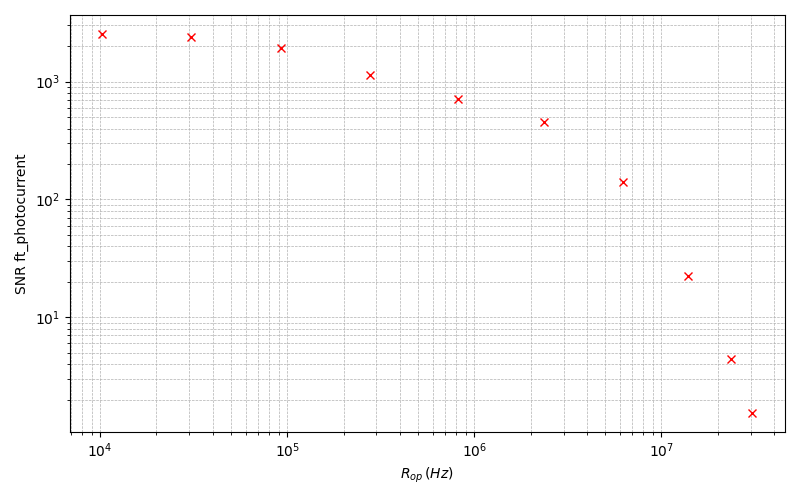

In [ ]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

axes.plot(R_op_list, SNR_list, 'x', color='red')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('$R_{op}\, (Hz)$')
axes.set_ylabel('SNR ft_photocurrent')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
""" np.savetxt('magnitude_signal_photocurrent_vs_n(T)_low_P_laser.txt',magnitude_signal_photocurrent)
np.savetxt('SNR_magnitude_signal_photocurrent_vs_n(T)_low_P_laser.txt', SNR_list)
np.savetxt('n(T)_low_P_laser_logspace.txt',n_list) """

## Final test with first optimized parameters

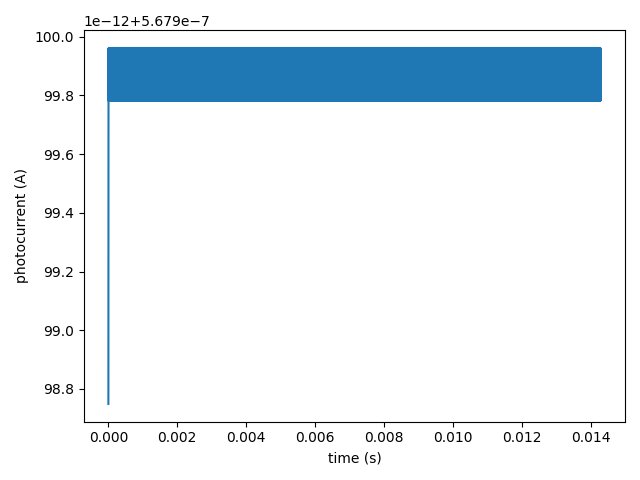

In [ ]:
initial_state = [0, 0, 0]
t_span = [0, 10000/(gamma*B_0)]
sampling_rate = int(3*gamma*B_0) #adjust to have a frequency that allows me to detect the oscillation
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate)  

solution = solve_bloch_equations(initial_state, t_span, t_eval, gamma = gamma, B_0 = B_0, B_1 = B_1, omega = omega, Gamma = Gamma, R_op = R_op, S_0=S_0)

t = solution.t
Sx, Sy, Sz = solution.y

points_to_skip = 0
dt = t_eval[1]-t_eval[0]
freq = np.fft.rfftfreq(len(t_eval[points_to_skip:]), d=dt)
#freq_shifted = np.abs(np.fft.fftshift(freq))

I_z_t = np.zeros(len(Sy))
test = np.zeros(len(Sy))

for j, Mz in enumerate(Sz):
    I_z_t[j] = absorption_equation(z = z_cell, I_0 = I, sigma = sigma, n=n_list[2], M= Mz)

R = 0.568 #A/W, for standard thorlabs Si photodiode

P_z_t = I_z_t * (np.pi*(beam_diameter/2)**2)
photocurrent_z_t = R*P_z_t

ft_photocurrent = np.abs(np.fft.rfft(photocurrent_z_t))
%matplotlib widget
fig,axes=plt.subplots()
axes.plot(t,photocurrent_z_t)
axes.set_xlabel('time (s)')
axes.set_ylabel('photocurrent (A)')
plt.tight_layout()
plt.show()

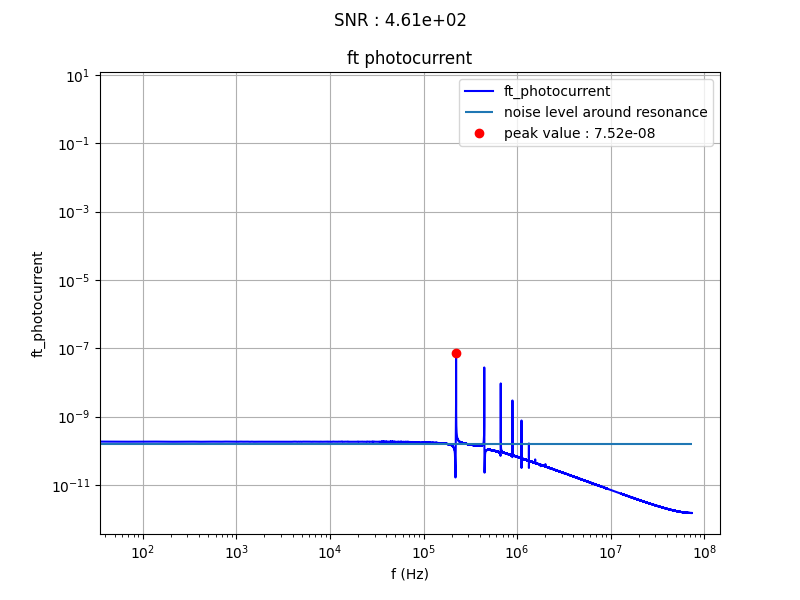

In [ ]:
mask = (freq > (2*gamma*B_0/(2*np.pi) - 0.1*2*gamma*B_0/(2*np.pi))) & (freq < (2*gamma*B_0/(2*np.pi) + 0.1*2*gamma*B_0/(2*np.pi)))

subarray = ft_photocurrent[mask]

mask_lower = (freq > 2*gamma*B_0/(2*np.pi) - 0.5 * 2*gamma*B_0/(2*np.pi)) & (freq < 2*gamma*B_0/(2*np.pi) - 0.1 * 2*gamma*B_0/(2*np.pi))

mask_upper = (freq > 2*gamma*B_0/(2*np.pi) + 0.1 * 2*gamma*B_0/(2*np.pi)) & (freq < 2*gamma*B_0/(2*np.pi) + 0.5 * 2*gamma*B_0/(2*np.pi))

mask2 = mask_lower | mask_upper

magnitude = np.max(subarray) - np.mean(ft_photocurrent[mask2])
SNR = np.max(subarray) / np.mean(ft_photocurrent[mask2])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

fig.suptitle('SNR : {:.2e}'.format(SNR))

axes.plot(freq, ft_photocurrent, color='blue', label='ft_photocurrent')
#axes.vlines(2*gamma*B_0/(2*np.pi), min(ft_photocurrent), max(ft_photocurrent), color = 'k', label='$2f_{L} = 2\gamma B_0 $')
axes.hlines(np.mean(ft_photocurrent[mask2]), xmin=freq[0], xmax=freq[-1], label='noise level around resonance')
axes.plot(freq[np.where(ft_photocurrent==np.max(subarray))],magnitude, 'ro', label = 'peak value : {:.2e}'.format(np.max(subarray)))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_title('ft photocurrent')
axes.set_xlabel('f (Hz)')
axes.set_ylabel('ft_photocurrent')
axes.legend()
axes.grid(True)

plt.show()

replotting

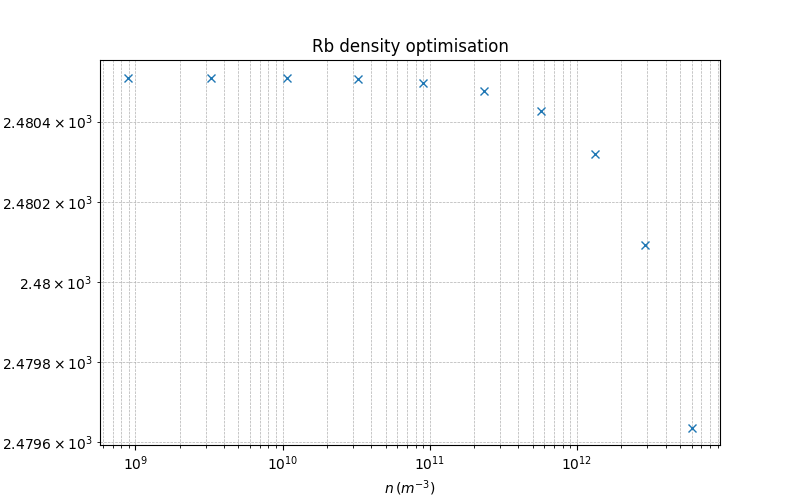

In [ ]:
file1 = 'SNR_magnitude_signal_photocurrent_vs_n(T).txt'
file2 = 'n(T)_logspace.txt'

y = np.loadtxt(file1)
x = np.loadtxt(file2)

plt.figure(figsize=(8,5))
plt.loglog(x,y, 'x')
plt.title('Rb density optimisation')
plt.xlabel('$n\, (m^{-3})$')
plt.ylabel('SNR photocurrent (U.A.)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Sources



[1] : 'How to build a magnetometer with thermal atomic vapor: a tutorial', A. Fabricant, I. Novikova, G. Bison. <br>
[2] : 'Rubidium 87 D Line Data', Daniel A. Steck <br>
[3] : "In-situ measurement and close-loop control of atomic number density in an optically pumped magnetometer based on light absorption", ZiaoLiu et al 2023